## Quantum LSTM for classification tasks

#### Let us start by training a Quantum Long Short-Term Memory model for the binary classification of IMDB movie reviews.

#### We will work with a preprocessed dataset, in which every movie review have been shorten to its most relevant 5 words.

In [1]:
import sys; sys.path.append('../src')
import torch
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
cmap = get_cmap('tab20c')
colors = cmap.colors

/var/folders/x8/4nwfzz4d2tb_w79xcl4k8gxxn0kqjv/T/ipykernel_33206/3623456619.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20c')


In [48]:
data = '../Datasets/imdb_top5_vocab20.txt'
data = '../../../../Downloads/tcga_top5.txt'

with open(data, 'r') as file: reviews = file.readlines()

classes = list(set(list(int(review[:2]) for review in reviews)))
class_dist = {c: 0 for c in classes}
for review in reviews: class_dist[int(review[:2])] += 1
train_classes = [0,1,2]

#### The first character of each datapoint is a label. Good reviews are assigned label $1$, while bad ones are assigned label $0$.
#### For this tutorial, we will generate a balanced training set. 

In [49]:
from qlstm_aux import subset_idxs_dist

train_size = 60
balanced = True
randomized = True

train_idxs, train_dist = subset_idxs_dist(reviews, train_classes, train_size, balanced, randomized)

In [50]:
print(train_idxs)
print(train_dist)

[6147, 6219, 461, 880, 1003, 4388, 1911, 3642, 3269, 1891, 2876, 4300, 4934, 1014, 3801, 4014, 3520, 853, 1737, 5394, 4758, 5397, 1253, 655, 2723, 2695, 5568, 1927, 473, 2030, 3110, 5428, 5014, 1514, 4639, 5479, 1214, 4366, 3321, 4418, 5435, 2274, 2816, 4050, 3534, 3242, 872, 3357, 700, 2284, 4039, 1257, 5459, 1992, 565, 6095, 5793, 4853, 5466, 2472]
{0: 20, 1: 20, 2: 20}


In [51]:
from qlstm_aux import words_to_idxs
words_to_idxs = words_to_idxs(reviews, train_idxs)

In [52]:
print(len(words_to_idxs))
print(words_to_idxs)

82
{'mm': 0, 'margins': 1, 'section': 2, 'present': 3, 'attached': 4, 'ii': 5, 'uuid': 6, 'high': 7, 'positive': 8, 'cells': 9, 'biopsy': 10, 'invasive': 11, 'site': 12, 'formalin': 13, 'entirely': 14, 'negative': 15, 'fresh': 16, 'frozen': 17, 'uninvolved': 18, 'date': 19, 'page': 20, 'iii': 21, 'number': 22, 'stage': 23, 'areas': 24, 'parenchyma': 25, 'portion': 26, 'sectioned': 27, 'metastatic': 28, 'metastasis': 29, 'reviewed': 30, 'pathologic': 31, 'yellow': 32, 'measures': 33, 'labeled': 34, 'posterior': 35, 'additional': 36, 'anterior': 37, 'excision': 38, 'blue': 39, 'performed': 40, 'patient': 41, 'examination': 42, 'area': 43, 'description': 44, 'shows': 45, 'resection': 46, 'cell': 47, 'mass': 48, 'consists': 49, 'size': 50, 'representative': 51, 'white': 52, 'cut': 53, 'vascular': 54, 'differentiated': 55, 'adipose': 56, 'small': 57, 'examined': 58, 'diameter': 59, 'clinical': 60, 'surface': 61, 'soft': 62, 'focal': 63, 'free': 64, 'identified': 65, 'total': 66, 'red': 67, 

#### Next, we define the model we want to train.

In [53]:
embedding_dim = 8
hidden_dim = 6
num_words = len(words_to_idxs)
num_labels = len(train_classes)
num_qubits = 2
num_qlayers = 1
backend = 'default.qubit'

In [54]:
from qlstm_models import QLSTMClassifier

model = QLSTMClassifier(embedding_dim,
                        hidden_dim,
                        vocab_size=num_words,
                        tagset_size=num_labels,
                        n_qubits=num_qubits,
                        n_qlayers=num_qlayers,
                        ising=True,
                        probs=False,
                        backend=backend)

{'weights': (1, 2)}


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

weights = torch.tensor(list(pow(train_size/len(train_classes)/train_dist[key],3) for key in train_dist.keys()), dtype=torch.float)
learning_rate = 0.001

loss_function = nn.NLLLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
num_epochs = 50
training = {'loss': [], 'acc': []}

In [ ]:
from numpy import mean, around
from qlstm_aux import prepare_sequence

for epoch in range(num_epochs):

    rank_losses = []
    rank_preds = []
    rank_targets = []
    accuracy = torch.tensor([0], dtype=torch.float32)
    
    if epoch == num_epochs-1: rank_confusion = {c: [] for c in train_classes}

    for k, i in enumerate(train_idxs):
        
        model.zero_grad(set_to_none=False)
        
        if i != -1:
            sentence = reviews[i][2:-1].split()
            sentence_in = prepare_sequence(sentence, words_to_idxs)
            label = list(0 for j in range(len(train_classes)))
            for j, key in enumerate(train_dist.keys()):
                if int(reviews[i][:2]) == key: label[j] += 1
            label = torch.tensor(label, dtype=torch.long)
            rank_targets.append(label)

            scores = model(sentence_in)
            loss = loss_function(scores, torch.tensor([label.argmax(dim=-1)]))
            loss.backward()
            rank_losses.append(float(loss))
            pred = list(0 for j in range(len(train_classes)))
            pred[scores.argmax().item()] += 1
            pred = torch.tensor(pred, dtype=torch.long)
            rank_preds.append(pred)

        else: loss = torch.tensor([-100.], dtype=torch.float32)

        optimizer.step()

    avg_loss = mean(rank_losses)
    training['loss'].append(avg_loss)

    preds = torch.cat(rank_preds)
    targets = torch.cat(rank_targets)
    corrects = (preds == targets)
    accuracy = corrects.sum().float() / float(targets.size(0))
    training['acc'].append(accuracy)

    if epoch%10==0: print('Loss: {}\tAccuracy: {}'.format(around(avg_loss,4), around(accuracy,4)))

Loss: -0.333	Accuracy: 0.5555999875068665
Loss: -0.3815	Accuracy: 0.6777999997138977
Loss: -0.5242	Accuracy: 0.7444000244140625
Loss: -0.585	Accuracy: 0.7444000244140625
Loss: -0.6076	Accuracy: 0.7555999755859375


In [ ]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(3.375*3/2, 3.375*4/3), dpi=200)
for ax in axs.ravel():
    ax.tick_params(labelsize='xx-small')
axs[0].set_ylabel('Loss', fontsize='x-small')
axs[1].set_ylabel('Accuracy', fontsize='x-small')
axs[1].set_xlabel('Epoch', fontsize='x-small')
axs[0].plot(training['loss'], lw=1, color=colors[1], label='LSTM');
axs[1].plot(training['acc'], lw=1, color=colors[1], label='LSTM');

In [44]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
cmap = get_cmap('tab20c')
colors = cmap.colors

/var/folders/x8/4nwfzz4d2tb_w79xcl4k8gxxn0kqjv/T/ipykernel_31960/924722365.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20c')


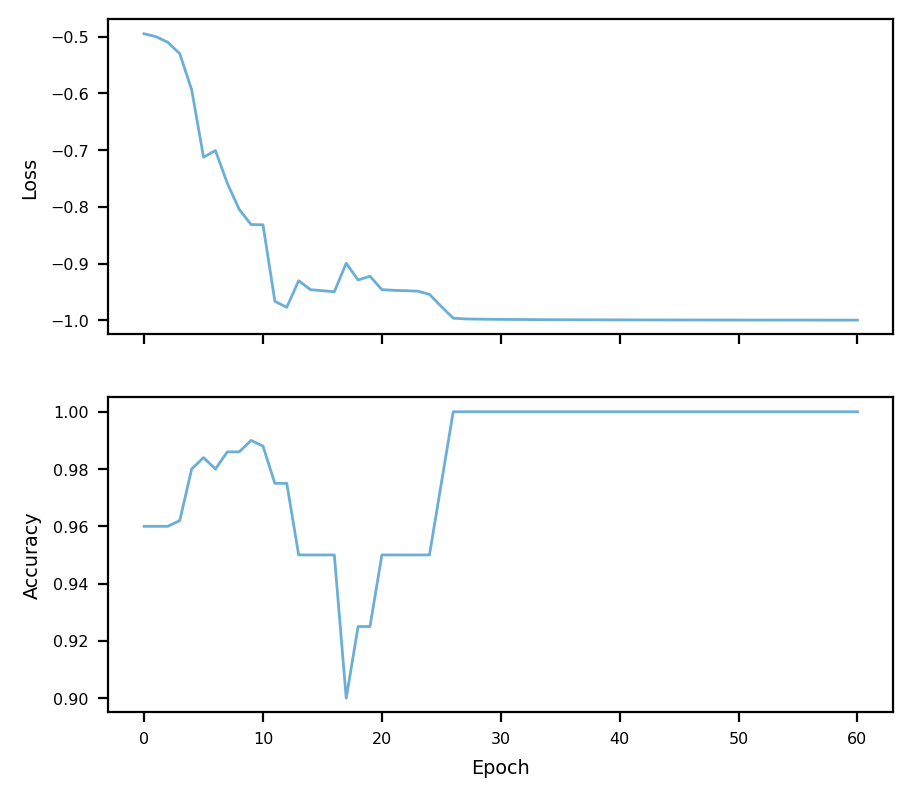

In [45]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(3.375*3/2, 3.375*4/3), dpi=200)
for ax in axs.ravel():
    ax.tick_params(labelsize='xx-small')
axs[0].set_ylabel('Loss', fontsize='x-small')
axs[1].set_ylabel('Accuracy', fontsize='x-small')
axs[1].set_xlabel('Epoch', fontsize='x-small')
axs[0].plot(training['loss'], lw=1, color=colors[1], label='QLSTM');
axs[1].plot(training['acc'], lw=1, color=colors[1], label='QLSTM');